# Import packages

In [1]:
# Suppress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = '..//../'

# Data input
## Frog data (response variable)
We use the functions included in the benchmark file to collect the frog data from the provided training data. We search for frogs in the 5 evaluation regions and an additional 4 regions on other parts of Australia's coast, limited to frogs observed between the start of 2015 and the present day. We do this by providing `year_range` and `bbox` parameters to the `get_frogs` function defined below.

In [2]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

In [3]:
bboxs=[
    # from submission file
    (144.8,-38.5,145.8,-37.5), 
    (150.7,-33.5,151.7,-32.5), 
    (152.6,-29.0,153.6,-28.0),
    (145.0,-17.7,146.0,-16.7),
    (115.7,-32.5,116.7,-31.5),
    # Additional regions
    (148.8, -35.7, 149.8, -34.7),
    (152.3, -30.7, 153.3, -29.7),
    (152.1, -27.3 , 153.1, -26.3),
    (130.8, -12.8, 131.8, -11.8),
    
]
    
# Load in data

frog_datas = []
for bbox in bboxs:
    frog_datas.append(get_frogs(data_path+'/training_data/occurrence.txt', 
                                year_range=(2015, 2022), bbox=bbox))

In [4]:
target_species = 'Litoria Fallax'

for i, frog_data in enumerate(frog_datas):
    frog_datas[i] = (
        frog_data
        # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
        # as well as a key for joining (later)
        .assign(
            occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
        ).reset_index(drop=True)
        .assign(key=lambda x: x.index)
    )

## Weather data (predictor variable) 
We modified the `get_terraclimate` function from the benchmark file to group the weather data by month and take the maximum value, minimum value, mean, and standard deviation of each of our chosen measurements. 

In [5]:
def get_terraclimate_all(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Returns terraclimate data.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').compute()
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        data = data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return data

def get_terraclimate_months(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month."""
    ds = get_terraclimate_all(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    ds_month = [ds.groupby('time.month').max(dim='time'), 
                ds.groupby('time.month').min(dim='time'),
                ds.groupby('time.month').mean(dim='time'),
                ds.groupby('time.month').std(dim='time')]    
    return ds_month

def get_terraclimate(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month and make each month/asset a new variable."""
    ds_list = get_terraclimate_months(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    # hard code in labels for quantities. order is abritrary from get_terraclimate_months
    quantities = ['max','min','mean','std']

        # sets_list is a list of lists of datasets, each dataset has data for each metric/quantity pair
        # I need to unpack it twice. 
    sets_list = []
    for count, ds in enumerate(ds_list):
        sets = [
            ds.sel(month=month
                ).rename(
            {var: ' '.join((str(month), var, quantities[count])) for var in list(ds.keys())}
        ).drop_vars('month')
        for month in ds.month.values
        ]
        sets_list.append(sets)
    ds = xr.merge(
            # unpack each list in sets_list and merge into a larger dataset
        [xr.merge(sets_list[i]) for i in range(len(sets_list))]
            # merge these larger datasets into a dataset and
            # convert it into a data array, and rename the variable to band
        ).to_array().rename(variable='band')   
    return ds

We collect the weather data from January 2015 to December 2019, giving us 5 years worth of data for each region. We have selected to use the maximum air temperature, minimum air temperature, precipitation, and soil moisture content as the measurements in our model.

In [6]:
# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

interp_dims = (512, 512)

weather_datas = []
for bbox in bboxs:
    weather_datas.append(
        get_terraclimate(bbox, time_slice=time_slice, 
        assets=assets, interp_dims=interp_dims, verbose=True))

Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image


# Data preparation 

## Joining frogs to their climate data
We use the included function to join the frogs to their matching weather data. We iterate over the regions and then combine to make one large dataset containing frogs and weather from all 9 regions.

In [7]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
model_datas = []
for frog_data, weather_data in zip(frog_datas, weather_datas):    
    model_datas.append(join_frogs(frog_data, weather_data))

model_data = pd.concat(model_datas).dropna().reset_index(drop=True)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,...,9 soil min,9 soil std,9 tmax max,9 tmax mean,9 tmax min,9 tmax std,9 tmin max,9 tmin mean,9 tmin min,9 tmin std
0,1633803922,2017-08-05 20:51:00,Australia,Australia,Victoria,-38.045122,145.326047,Crinia Signifera,0,0,...,58.0,64.724030,17.099998,16.540001,15.800003,0.535163,8.400002,7.180002,6.500000,0.652381
1,3384896595,2021-10-07 07:58:39,Australia,Australia,Victoria,-38.030947,145.432053,Crinia Signifera,0,1,...,133.0,58.321865,16.599998,16.080000,15.400002,0.526877,7.800003,6.600001,5.900002,0.648074
2,3463456338,2018-11-09 00:00:00,Australia,Australia,Victoria,-38.088716,145.722909,Crinia Signifera,0,2,...,98.0,69.232941,17.099998,16.620001,16.099998,0.396988,8.000000,6.720000,6.099998,0.661514
3,3463456499,2019-07-30 00:00:00,Australia,Australia,Victoria,-37.807553,145.263607,Crinia Signifera,0,3,...,80.0,42.371689,17.099998,16.480000,15.599998,0.620967,7.800003,6.560002,5.800003,0.671118
4,3463456516,2020-08-23 00:00:00,Australia,Australia,Victoria,-37.991842,145.118825,Crinia Signifera,0,4,...,18.0,37.986313,17.800003,17.160002,16.400002,0.595316,9.000000,7.740001,7.000000,0.674092


## Downsampling data
Our training dataset contained 25,733 absence points and 13,839 presence points over all the geographical areas sampled, a nearly 2:1 imbalance.

We developed a method to downsample the absence points while preserving isolated ones. 

In [8]:
model_data.value_counts('occurrenceStatus')

occurrenceStatus
0    25733
1    13839
dtype: int64

In [9]:
grid_size = 24

target_species_frog_data = model_data[model_data.occurrenceStatus == 1]

n = len(target_species_frog_data)

keep = pd.DataFrame(columns=model_data.columns)
to_downsample = pd.DataFrame(columns=model_data.columns)

non_target_species_frog_data = model_data[model_data.occurrenceStatus == 0]

for i in range(grid_size):
    for j in range(grid_size):
        for min_lon, min_lat, max_lon, max_lat in bboxs:
            non_target_frogs_in_pixel = non_target_species_frog_data.loc[
                (non_target_species_frog_data['decimalLatitude'] > min_lat + j/grid_size) & 
                (non_target_species_frog_data['decimalLatitude'] <= min_lat + (j+1)/grid_size) &
                (non_target_species_frog_data['decimalLongitude'] > min_lon + i/grid_size) &
                (non_target_species_frog_data['decimalLongitude'] <= min_lon + (i+1)/grid_size)
            ]
            if len(non_target_frogs_in_pixel) >= 1:
                keep_in_pixel = non_target_frogs_in_pixel.sample(1)
                keep = pd.concat((keep, keep_in_pixel))
                to_downsample = pd.concat((to_downsample, non_target_frogs_in_pixel.drop(keep_in_pixel.index)))

n_keep = len(keep)

if n_keep < n:
    keep = pd.concat((keep, to_downsample.sample(n - n_keep)))
    
model_data = (
    keep
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)

In [10]:
model_data.value_counts('occurrenceStatus')

occurrenceStatus
0    13839
1    13839
dtype: int64

We have downsampled our off-target data points so that our model data contains an equal number of target and off-target data points, while preserving the isolated instances off-target frogs.

# Model building
We chose to use a Random Forest Classifier model for this model. This gave us the most accurate predictions. 

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [12]:
full_model = make_pipeline(StandardScaler(), RandomForestClassifier())
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
y = model_data.occurrenceStatus.astype(int)

# Fit model
full_model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

## Hyperparameter optimization
The built in functions for this task such as GridSearchCV kept crashing on my PC, so I wrote code to break the process into smaller parts and evaluated each individually. 

In [13]:
class_weight = ['balanced','balanced_subsample']
for i in class_weight:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(class_weight=i)).fit(X, y)
    predictions = a.predict(X)
    print('class_weight: '+i, f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


class_weight: balanced F1 Score: 0.8699
class_weight: balanced_subsample F1 Score: 0.8702


In [14]:
n_estimators = [10, 50, 100, 200, 300, 400]
for i in n_estimators:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=i)).fit(X, y)
    predictions = a.predict(X)
    print("n_estimators: "+str(i), f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


n_estimators: 10 F1 Score: 0.8698
n_estimators: 50 F1 Score: 0.8699
n_estimators: 100 F1 Score: 0.8703
n_estimators: 200 F1 Score: 0.8702
n_estimators: 300 F1 Score: 0.8703
n_estimators: 400 F1 Score: 0.8702


In [15]:
min_samples_split = [2, 5, 10, 15, 20, 30]
for i in min_samples_split:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(
        min_samples_split=i,
        class_weight='balanced',
        n_estimators=300,
    )).fit(X, y)
    predictions = a.predict(X)
    print("min_samples_split: "+str(i), f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


min_samples_split: 2 F1 Score: 0.8702
min_samples_split: 5 F1 Score: 0.8702
min_samples_split: 10 F1 Score: 0.87
min_samples_split: 15 F1 Score: 0.87
min_samples_split: 20 F1 Score: 0.8697
min_samples_split: 30 F1 Score: 0.8695


In [16]:
n_estimators = [200, 225, 250, 275, 300]
for i in n_estimators:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(
        n_estimators=i,
        class_weight='balanced',
        min_samples_split=5,
    )).fit(X,y)
    predictions = a.predict(X)
    print("n_estimators: "+str(i), f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


n_estimators: 200 F1 Score: 0.8702
n_estimators: 225 F1 Score: 0.8702
n_estimators: 250 F1 Score: 0.8702
n_estimators: 275 F1 Score: 0.8702
n_estimators: 300 F1 Score: 0.8701


Re-evaluate the `class_weight` options with the refined values of `n_estimators` and `min_sample_split`.

In [17]:
class_weight = ['balanced','balanced_subsample']
for i in class_weight:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(
        n_estimators=250,
        class_weight=i,
        min_samples_split=5,
    )).fit(X,y)
    predictions = a.predict(X)
    print("class_weight: "+i, f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


class_weight: balanced F1 Score: 0.8702
class_weight: balanced_subsample F1 Score: 0.8703


## Model training
Using the hyperparameters determined from the above process, we train our model with the downsampled data.

In [18]:
full_model = make_pipeline(StandardScaler(), RandomForestClassifier(
    n_estimators=250,
    class_weight='balanced_subsample',
    min_samples_split=5,
    ))
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
y = model_data.occurrenceStatus.astype(int)

# Fit model
full_model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_split=5,
                                        n_estimators=250))])

# Results on train/test data
## In-sample results
Predict the frogs in the training set from the weather data in the training set.

In [19]:
in_sample_predictions = full_model.predict(X)

## Out-of-sample results
### Stratified k-fold cross validation

In [20]:
cv_model = full_model

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))


Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10


### Evaluation regions dataset
Construct a testing dataset from the 5 evaluation regions with no down-sampling.

In [21]:
test_data = pd.concat(model_datas[0:5]).dropna().reset_index(drop=True)

In [22]:
test_X = (
    test_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
test_y = test_data.occurrenceStatus.astype(int)
out_of_sample_preds = full_model.predict(test_X)

# Accuracy metrics 
## In-sample results

In [23]:
print("In sample "+f"F1 Score: {np.mean(f1_score(y, in_sample_predictions)).round(2)}")
print("In sample "+f"Accuracy: {np.mean(accuracy_score(y, in_sample_predictions)).round(2)}")

In sample F1 Score: 0.87
In sample Accuracy: 0.86


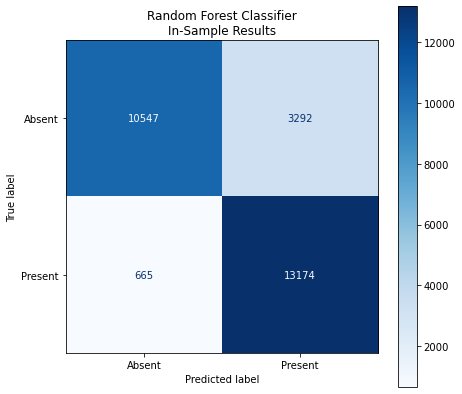

In [24]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Random Forest Classifier\nIn-Sample Results')
plt.show()

## Out-of-sample accuracy metrics
### Stratified k-folds accuracy metrics

In [25]:
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")


Metrics averaged over 10 trials:
F1: 0.86
Accuracy: 0.85


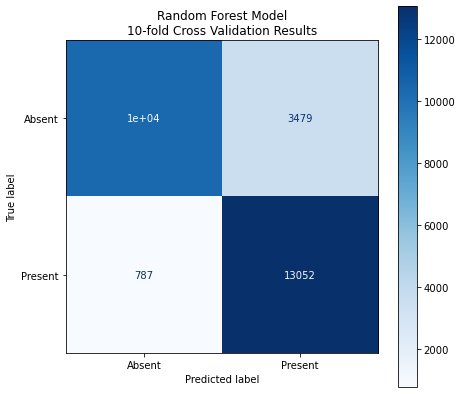

In [26]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Random Forest Model\n10-fold Cross Validation Results')
plt.show()

### Evaluation regions dataset accuracy metrics

In [27]:
print("Out of sample "+f"F1 Score: {np.mean(f1_score(test_y, out_of_sample_preds)).round(2)}")
print("Out of sample "+f"Accuracy: {np.mean(accuracy_score(test_y, out_of_sample_preds)).round(2)}")

F1 Score: 0.76
Accuracy: 0.8


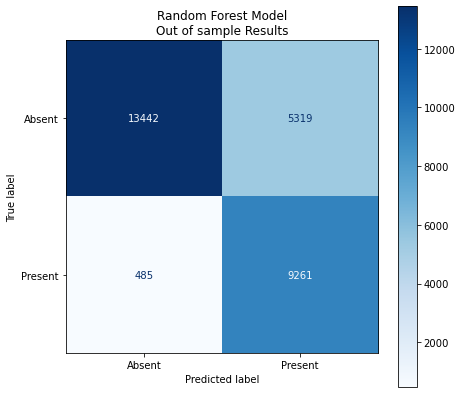

In [28]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, test_X, test_y,
                                             display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Random Forest Model\nOut of sample Results')
plt.show()

# Pickling the model 

In [29]:
import pickle

In [31]:
with open('rob_and_lealia_model.pkl','wb') as outpickle:
    pickle.dump(full_model, outpickle, pickle.HIGHEST_PROTOCOL)